# Exercise

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression

# Set Matplotlib defaults
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


# Load data
df = pd.read_csv("data/ames.csv")


# Utility functions from Tutorial
def make_mi_scores(X, y):
    X = X.copy()
    
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

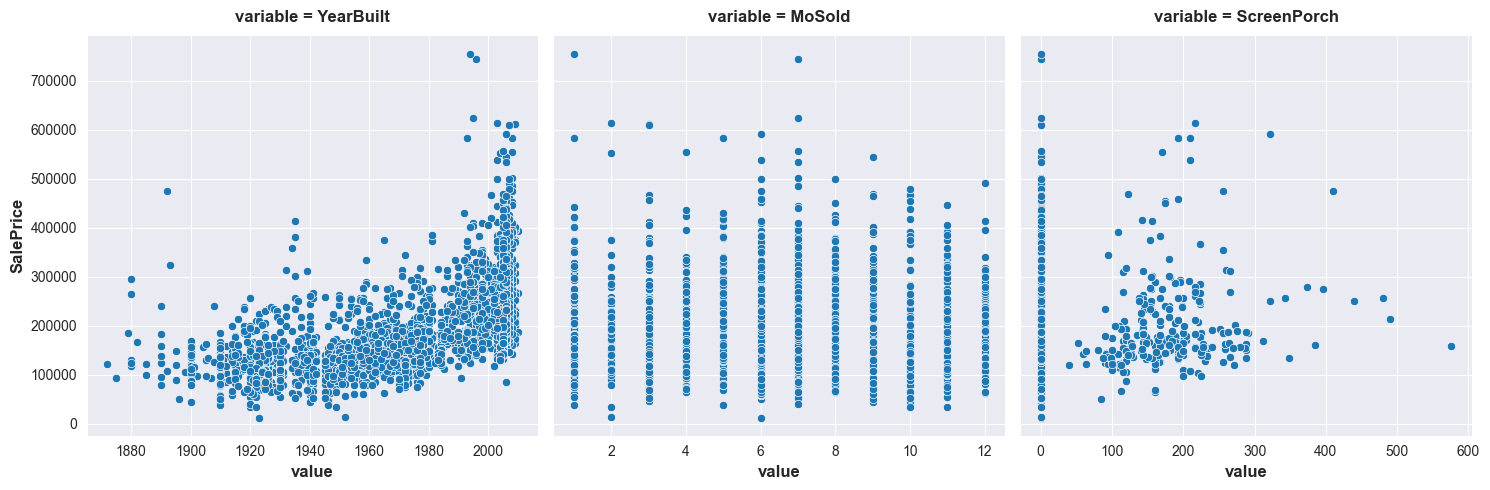

In [40]:
features = ["YearBuilt", "MoSold", "ScreenPorch"]
sns.relplot(
    x="value", y="SalePrice", col="variable", data=df.melt(id_vars="SalePrice", value_vars=features), facet_kws=dict(sharex=False),
);

Based on the plots, YearBuilt should have the highest MI score since knowing the year tends to constrain SalePrice to a smaller range of possible values. This is generally not the case for MoSold, however. Finally, since ScreenPorch is usually just one value, 0, on average it won't tell you much about SalePrice (though more than MoSold) .

In [41]:
X = df.copy()
y = X.pop('SalePrice')

X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YearSold,SaleType,SaleCondition
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141.0,31770.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,0.0,No_Pool,No_Fence,NaN,0.0,5,2010,WD,Normal
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80.0,11622.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,120.0,0.0,No_Pool,Minimum_Privacy,NaN,0.0,6,2010,WD,Normal
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81.0,14267.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,0.0,No_Pool,No_Fence,Gar2,12500.0,6,2010,WD,Normal
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93.0,11160.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,0.0,0.0,No_Pool,No_Fence,NaN,0.0,4,2010,WD,Normal
4,Two_Story_1946_and_Newer,Residential_Low_Density,74.0,13830.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,0.0,0.0,No_Pool,Minimum_Privacy,NaN,0.0,3,2010,WD,Normal


In [42]:
mi_scores = make_mi_scores(X, y)

Some common themes among most of these features are:

Location: Neighborhood
Size: all of the Area and SF features, and counts like FullBath and GarageCars
Quality: all of the Qual features
Year: YearBuilt and YearRemodAdd
Types: descriptions of features and styles like Foundation and GarageType
These are all the kinds of features you'll commonly see in real-estate listings (like on Zillow), It's good then that our mutual information metric scored them highly. On the other hand, the lowest ranked features seem to mostly represent things that are rare or exceptional in some way, and so wouldn't be relevant to the average home buyer.

In this step you'll investigate possible interaction effects for the BldgType feature. This feature describes the broad structure of the dwelling in five categories:

Bldg Type (Nominal): Type of dwelling

  1Fam	Single-family Detached	
  2FmCon	Two-family Conversion; originally built as one-family dwelling
  Duplx	Duplex
  TwnhsE	Townhouse End Unit
  TwnhsI	Townhouse Inside Unit
The BldgType feature didn't get a very high MI score. A plot confirms that the categories in BldgType don't do a good job of distinguishing values in SalePrice (the distributions look fairly similar, in other words):

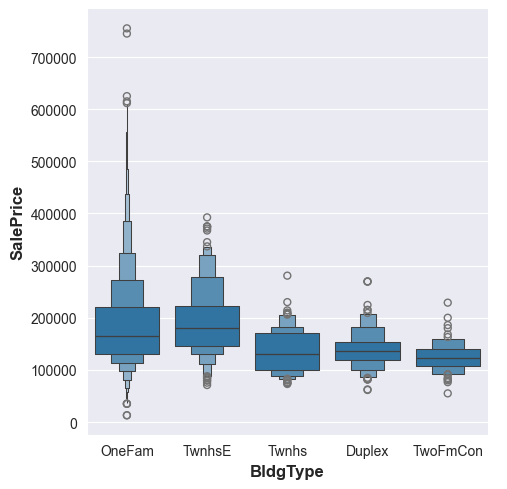

In [43]:
sns.catplot(x="BldgType", y="SalePrice", data=df, kind="boxen");

Still, the type of a dwelling seems like it should be important information. Investigate whether BldgType produces a significant interaction with either of the following:

GrLivArea  # Above ground living area
MoSold     # Month sold
Run the following cell twice, the first time with feature = "GrLivArea" and the next time with feature="MoSold":

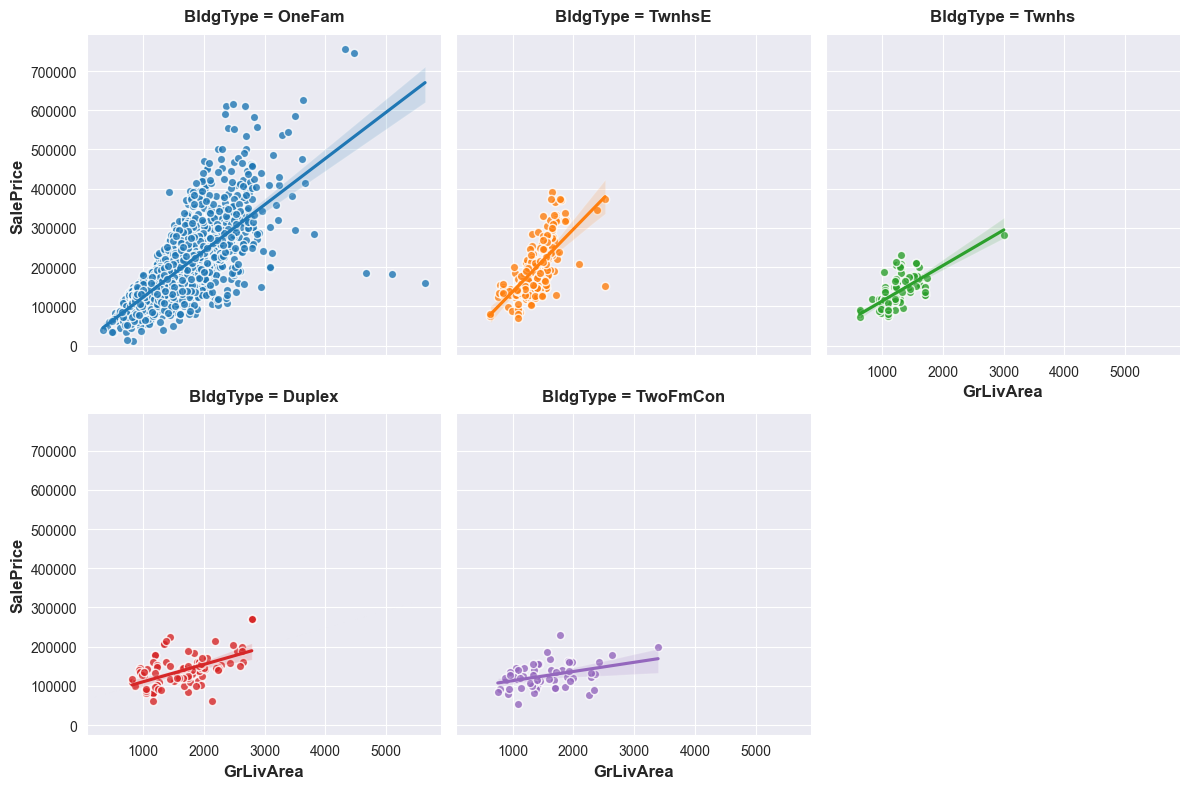

In [44]:
feature = "GrLivArea"

sns.lmplot(
    x=feature, y="SalePrice", hue="BldgType", col="BldgType",
    data=df, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
);

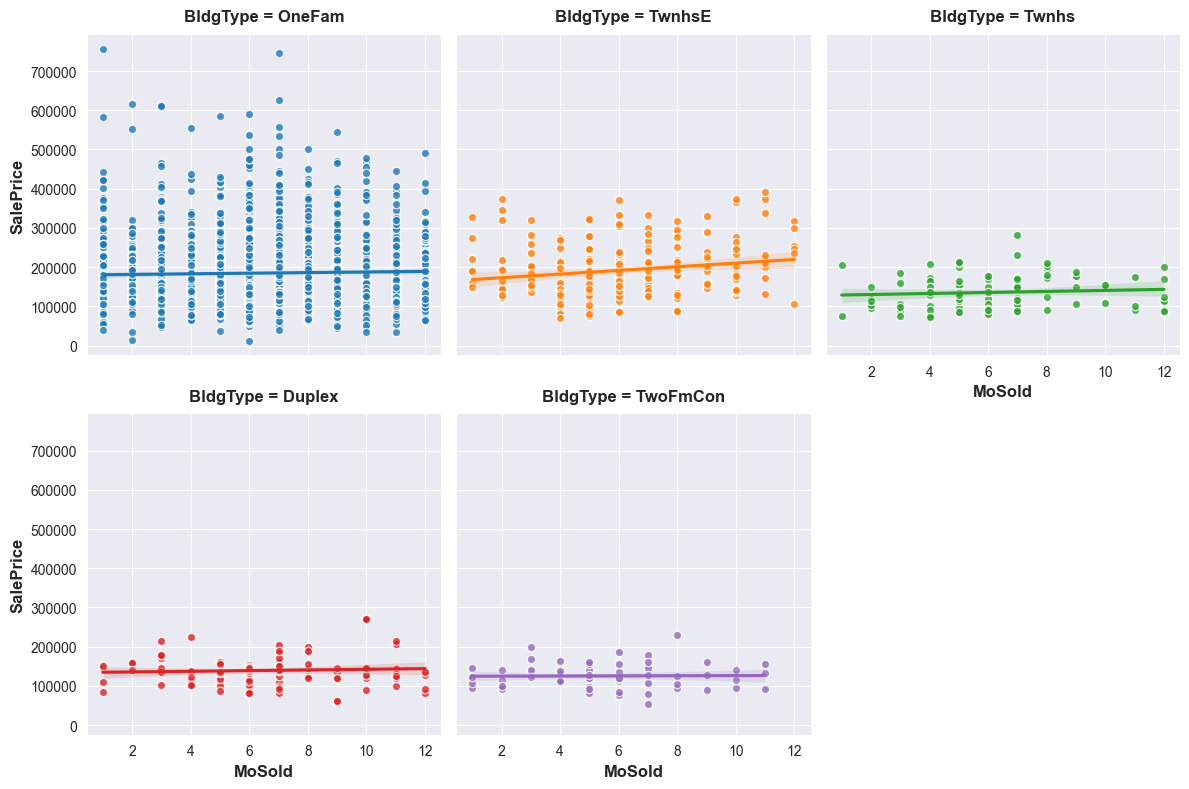

In [45]:
feature = "MoSold"

sns.lmplot(
    x=feature, y="SalePrice", hue="BldgType", col="BldgType",
    data=df, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
);

In [46]:
mi_scores.head(10)

OverallQual     0.581262
Neighborhood    0.569813
GrLivArea       0.496909
YearBuilt       0.437939
GarageArea      0.415014
TotalBsmtSF     0.390280
GarageCars      0.381467
FirstFlrSF      0.368825
BsmtQual        0.364779
KitchenQual     0.326194
Name: MI Scores, dtype: float64

Do you recognize the themes here? Location, size, and quality. You needn't restrict development to only these top features, but you do now have a good place to start. Combining these top features with other related features, especially those you've identified as creating interactions, is a good strategy for coming up with a highly informative set of features to train your model on.